In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2

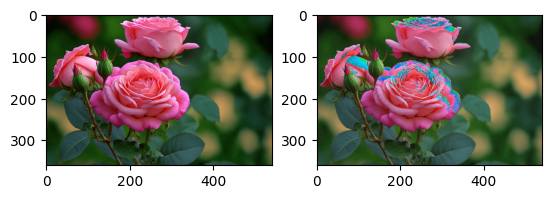

In [2]:
# 3.1.1 Pixel Point Operator
# sample images and basic nd array manipulation of images using matrix arithmetic operations
img = mpimg.imread("sample/flower.jpg")
fig, axis = plt.subplots(1, 2)
axis[0].imshow(img)
axis[1].imshow(img + (np.ones(img.shape) + 10).astype("uint8"))

plt.show()

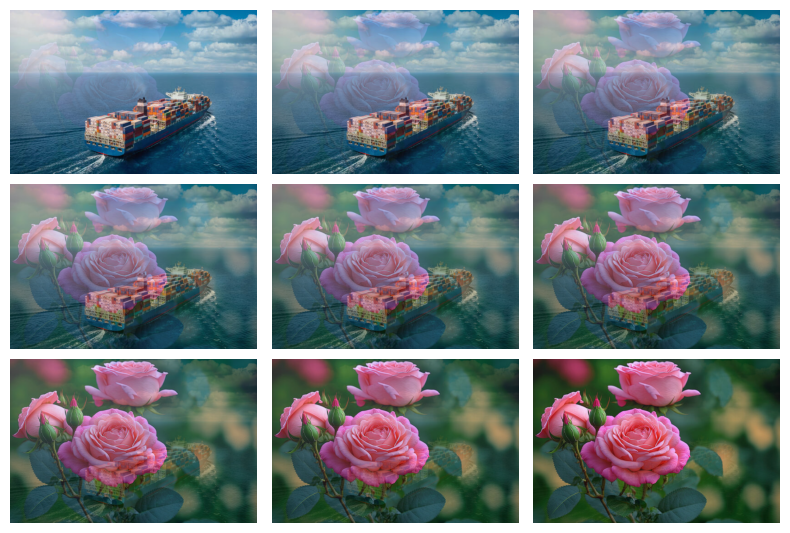

In [3]:
# 3.1.3 Compositing and matting

# calculation of RGBa with alpha, the color is derived by the following formula: C = (1 - a)B + aF
# where B stands for background and F stands for foreground, C is the resulting image

def derive_RGBa(background: np.ndarray, foreground: np.ndarray, alpha: float = 1.) -> np.ndarray:

    return np.round((1 - alpha) * background + alpha * foreground).astype("uint8")


img_foreground = mpimg.imread("sample/flower.jpg")
img_background = mpimg.imread("sample/ship.jpg")

width, height, channel = img_foreground.shape

fig, axis = plt.subplots(3, 3, figsize=(8, 8))

for a in range(9):
    axis[a//3, a % 3].imshow(
        derive_RGBa(
            background=img_background[:width, :height, :channel], 
            foreground=img_foreground, 
            alpha=0.1*(a+1)))
    axis[a//3, a % 3].axis("off")

plt.subplots_adjust(wspace=0.03, hspace=0.03)
fig.tight_layout(h_pad=-13.0)
plt.show()

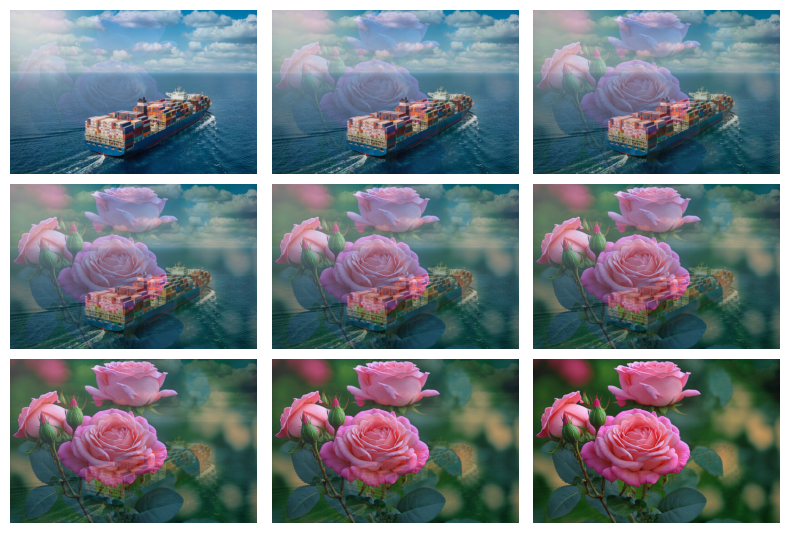

In [4]:
# For image alpha blending using OpenCV implementation
def opencv_read_jpg(filename: str) -> np.ndarray:

    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

def opencv_alpha_blend(background: np.ndarray, foreground: np.ndarray, alpha: float = 1.) -> np.ndarray:
    alpha_arr = np.full(foreground.shape, alpha, dtype="float")

    # Multiply the foreground with the alpha matte
    foreground = cv2.multiply(alpha_arr, foreground.astype("float"))

    # Multiply the background with ( 1 - alpha )
    background = cv2.multiply(1.0 - alpha_arr, background.astype("float"))

    # Add the masked foreground and background.
    out_image = cv2.add(foreground, background)

    return np.round(out_image).astype("uint8")


def opencv_alpha_blend_v2(background: np.ndarray, foreground: np.ndarray, alpha: float = 1.) -> np.ndarray:
    # gamma is the scalar value added to each entry in the resulting image, set to 0 in this case
    return cv2.addWeighted(foreground, alpha, background, 1 - alpha, 0)


cv_foreground = opencv_read_jpg("sample/flower.jpg")
cv_background = opencv_read_jpg("sample/ship.jpg")

width, height, channel = cv_foreground.shape

fig, axis = plt.subplots(3, 3, figsize=(8, 8))

for a in range(9):
    axis[a//3, a % 3].imshow(
        opencv_alpha_blend_v2(
            background=cv_background[:width, :height, :channel], 
            foreground=cv_foreground, 
            alpha=0.1*(a+1)))
    axis[a//3, a % 3].axis("off")

plt.subplots_adjust(wspace=0.03, hspace=0.03)
fig.tight_layout(h_pad=-13.0)
plt.show()


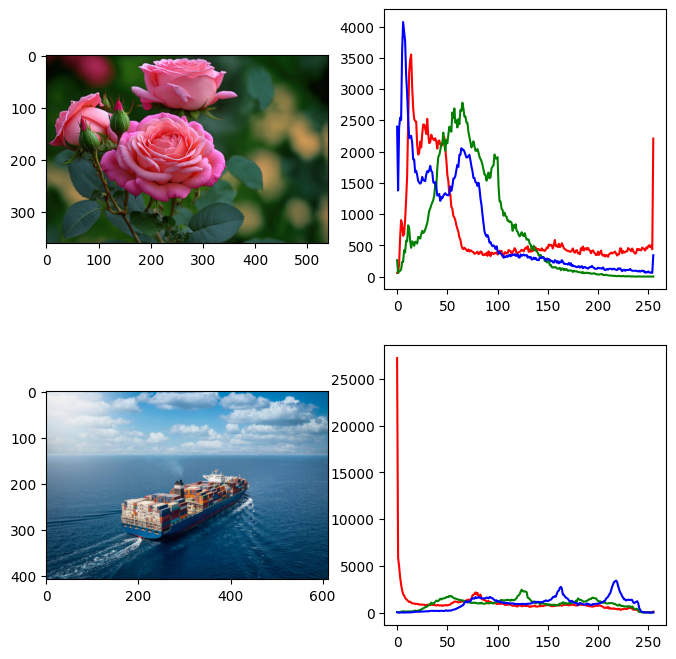

In [5]:
# 3.1.4 Histogram equalization
# picture histogram is the frequency of pixels at all intensity, where 8-bit color intensity (at all respective RGB channels) range from 0 to 255

def image_histogram(image: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    # 8-bit color range
    color_range = np.arange(2**8 + 1)
    total_pixels = image.shape[0] * image.shape[1]

    r = np.histogram(image[:, :, 0].reshape((total_pixels, )), bins=color_range)[0]
    g = np.histogram(image[:, :, 1].reshape((total_pixels, )), bins=color_range)[0]
    b = np.histogram(image[:, :, 2].reshape((total_pixels, )), bins=color_range)[0]

    return (r, g, b)

def plot_histogram(ax, histogram: tuple[np.ndarray, np.ndarray, np.ndarray]):
    r, g, b = histogram[0], histogram[1], histogram[2]
    x = np.arange(len(r))


    ax.plot(x, r, "r")
    ax.plot(x, g, "g")
    ax.plot(x, b, "b")

img1 = mpimg.imread("sample/flower.jpg")
img2 = mpimg.imread("sample/ship.jpg")

fig, axis = plt.subplots(2, 2, figsize=(8, 8))
axis[0, 0].imshow(img1)
plot_histogram(axis[0, 1], image_histogram(img1))
axis[1, 0].imshow(img2)
plot_histogram(axis[1, 1], image_histogram(img2))

plt.show()

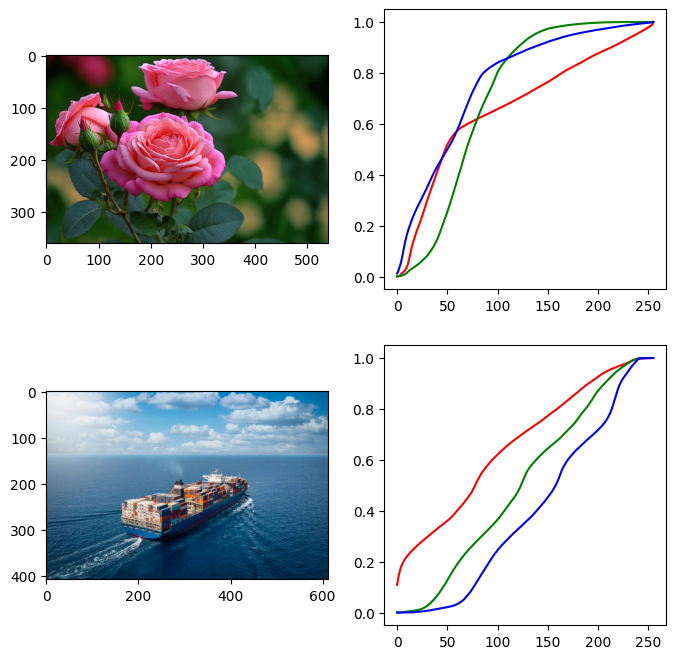

In [6]:
# after we have obtained the picture density probability functions f(I)
# we can now derive the cumulative density function of the histogram
# the derivation of the cumulative density, which is the percentile of the value of I, c(I) = c(I - 1) + h(I) / N,
# where c is the cumulative percentile function, h is the frequency function at intensity I, N is the total number of pixels of the image 

def cumulative_density(histogram: np.ndarray) -> np.ndarray:
    N = np.sum(histogram)
    cumulative = np.cumsum(histogram)

    return cumulative / N


def plot_cumulative_histogram(ax, histogram: tuple[np.ndarray, np.ndarray, np.ndarray]):
    r, g, b = histogram[0], histogram[1], histogram[2]
    x = np.arange(len(r))

    ax.plot(x, cumulative_density(r), "r")
    ax.plot(x, cumulative_density(g), "g")
    ax.plot(x, cumulative_density(b), "b")


img1 = mpimg.imread("sample/flower.jpg")
img2 = mpimg.imread("sample/ship.jpg")

fig, axis = plt.subplots(2, 2, figsize=(8, 8))
axis[0, 0].imshow(img1)
plot_cumulative_histogram(axis[0, 1], image_histogram(img1))
axis[1, 0].imshow(img2)
plot_cumulative_histogram(axis[1, 1], image_histogram(img2))

plt.show()

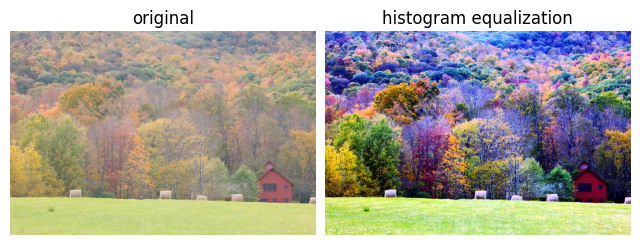

In [7]:
# now to perform histogram equalization
# to apply equalization, we need to find a mapping function f(I) = a c(I) + (1 - a) I, such that the probabily density is the same for all intensity I (0 ~ 255)
# Important: note that when working with 8-bit pixels, the c(I) function is re-scaled to the range of [0, 255]
# using numpy to implement equalization:
def mapping_function(cdf: np.ndarray) -> np.ndarray:
    cdf_masked = np.ma.masked_equal(cdf, 0)
    cdf_masked = (cdf_masked - cdf_masked.min()) * 255 / (cdf_masked.max() - cdf_masked.min())

    return np.round(np.ma.filled(cdf_masked, 0)).astype("uint8")

def histogram_equalization(image: np.ndarray) -> np.ndarray: 
    histogram = image_histogram(img)
    c_r = cumulative_density(histogram[0]) * 255
    c_g = cumulative_density(histogram[1]) * 255
    c_b = cumulative_density(histogram[2]) * 255

    c = np.array([mapping_function(c_r), mapping_function(c_g), mapping_function(c_b)])

    channels = c[0, image[..., 0]], c[1, image[..., 1]], c[2, image[..., 2]]

    return np.stack(channels, axis=-1) 


img = mpimg.imread("sample/forest.jpg")
new_image = histogram_equalization(img)

fig, axis = plt.subplots(1, 2, figsize=(8, 8))

axis[0].imshow(img)
axis[0].set_title("original")
axis[0].axis("off")
axis[1].imshow(new_image)
axis[1].set_title("histogram equalization")
axis[1].axis("off")

plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.show()

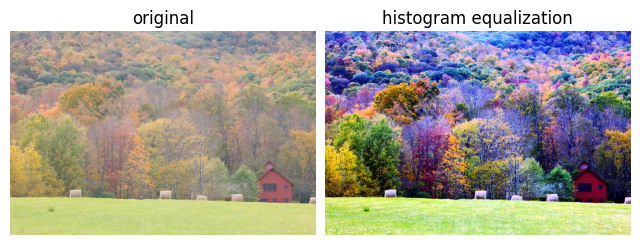

In [8]:
# open CV implementation of image equalization
img = cv2.cvtColor(cv2.imread("sample/forest.jpg"), cv2.COLOR_BGR2RGB)
R, G, B = cv2.split(img)
output_R = cv2.equalizeHist(R)
output_G = cv2.equalizeHist(G)
output_B = cv2.equalizeHist(B)

new_image = cv2.merge((output_R, output_G, output_B))

fig, axis = plt.subplots(1, 2, figsize=(8, 8))

axis[0].imshow(img)
axis[0].set_title("original")
axis[0].axis("off")
axis[1].imshow(new_image)
axis[1].set_title("histogram equalization")
axis[1].axis("off")

plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.show()

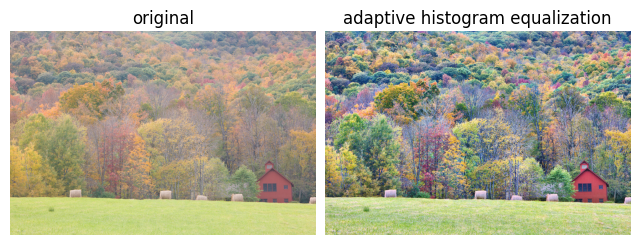

In [9]:
# Adaptive Histogram Equalization (AHE)
# Splitting the image into M x M smaller blocks and apply histogram equalization techniques to all the smaller blocks.
# For more efficient computation, the smaller blocks are non-overlapping, 
# after all smaller equalization operation completed, borders of different blocks to be removed by bi-linear interpolation method

# bilinear interpolation implementation
# note that bilinear interpolation can also be achieved by a proper 2D filtering kernel, (refer to chapter-3.2 notebook)
def bilinear_interpolate(image: np.ndarray, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    x0 = np.floor(x).astype("uint8")
    x1 = x0 + 1
    y0 = np.floor(y).astype("uint8")
    y1 = y0 + 1

    x0 = np.clip(x0, 0, image.shape[1]-1);
    x1 = np.clip(x1, 0, image.shape[1]-1);
    y0 = np.clip(y0, 0, image.shape[0]-1);
    y1 = np.clip(y1, 0, image.shape[0]-1);

    Ia = image[ y0, x0 ]
    Ib = image[ y1, x0 ]
    Ic = image[ y0, x1 ]
    Id = image[ y1, x1 ]

    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    return (Ia.T*wa).T + (Ib.T*wb).T + (Ic.T*wc).T + (Id.T*wd).T

# OpenCV implementation: 
# image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). 
# Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). 
# If noise is there, it will be amplified. To avoid this, contrast limiting is applied. 
# If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), 
# those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. 
# After equalization, to remove artifacts in tile borders, bilinear interpolation is applied.

img = cv2.cvtColor(cv2.imread("sample/forest.jpg"), cv2.COLOR_BGR2RGB)
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
R, G, B = cv2.split(img)
output_R = clahe.apply(R)
output_G = clahe.apply(G)
output_B = clahe.apply(B)

new_image = cv2.merge((output_R, output_G, output_B))

fig, axis = plt.subplots(1, 2, figsize=(8, 8))

axis[0].imshow(img)
axis[0].set_title("original")
axis[0].axis("off")
axis[1].imshow(new_image)
axis[1].set_title("adaptive histogram equalization")
axis[1].axis("off")

plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.show()